In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import tensorflow as tf1

In [2]:
# Activity mapping
Activity_Types = {'dws':1, 'jog':2, 'sit':3, 'std':4, 'ups':5, 'wlk':6}
Activity_Labels = list(Activity_Types.keys())

# Define folder path
data_folder = "A_DeviceMotion_data"
Folders = glob(f'{data_folder}/*_*')
Folders = [s for s in Folders if "csv" not in s]

Df_all_list = []
Exp = 0
Segment_Size = 400  # Segment the data into 400-sample frames

# Load all data
for j in Folders:
    Csv = glob(j + '/*')

    for i in Csv:
        df = pd.read_csv(i)
        
        # Add activity label, subject name, and experiment number
        df['Activity'] = Activity_Types[j[len(data_folder)+1:len(data_folder)+4]]
        df['Sub_Num'] = i[len(j)+1:-4]
        
        ExpNum = np.zeros((df.shape[0]))
        for k in range(0, df.shape[0] - Segment_Size, Segment_Size):
            ExpNum[range(k, k + Segment_Size)] = k / Segment_Size + Exp * 100
        df['Exp_num'] = ExpNum

        Df_all_list.append(df)
        Exp += 1

# Concatenate all data
Df_all = pd.concat(Df_all_list, axis=0)

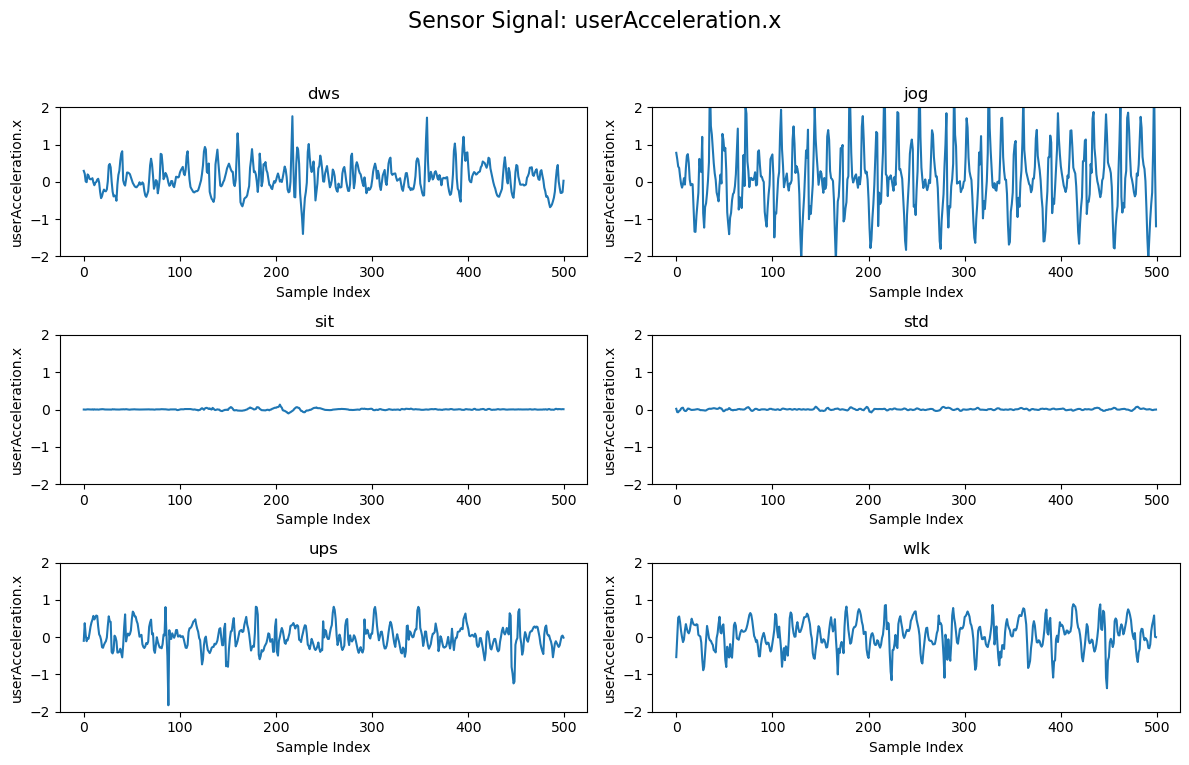

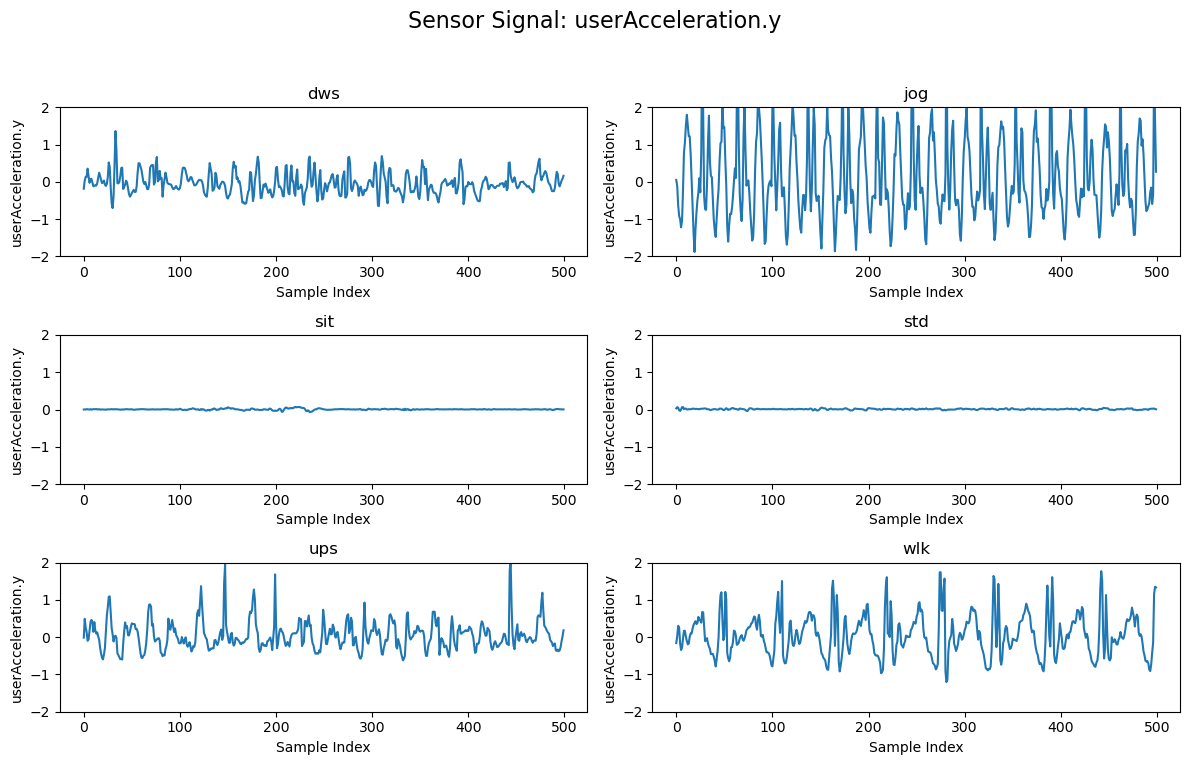

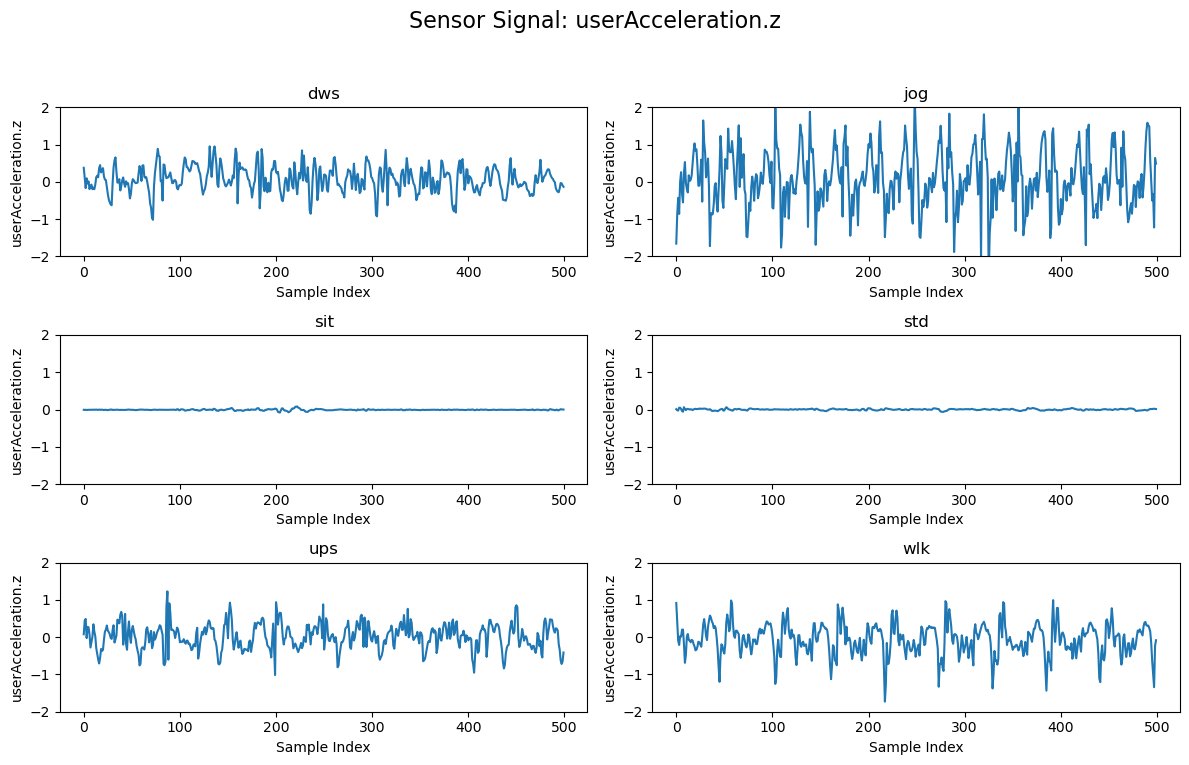

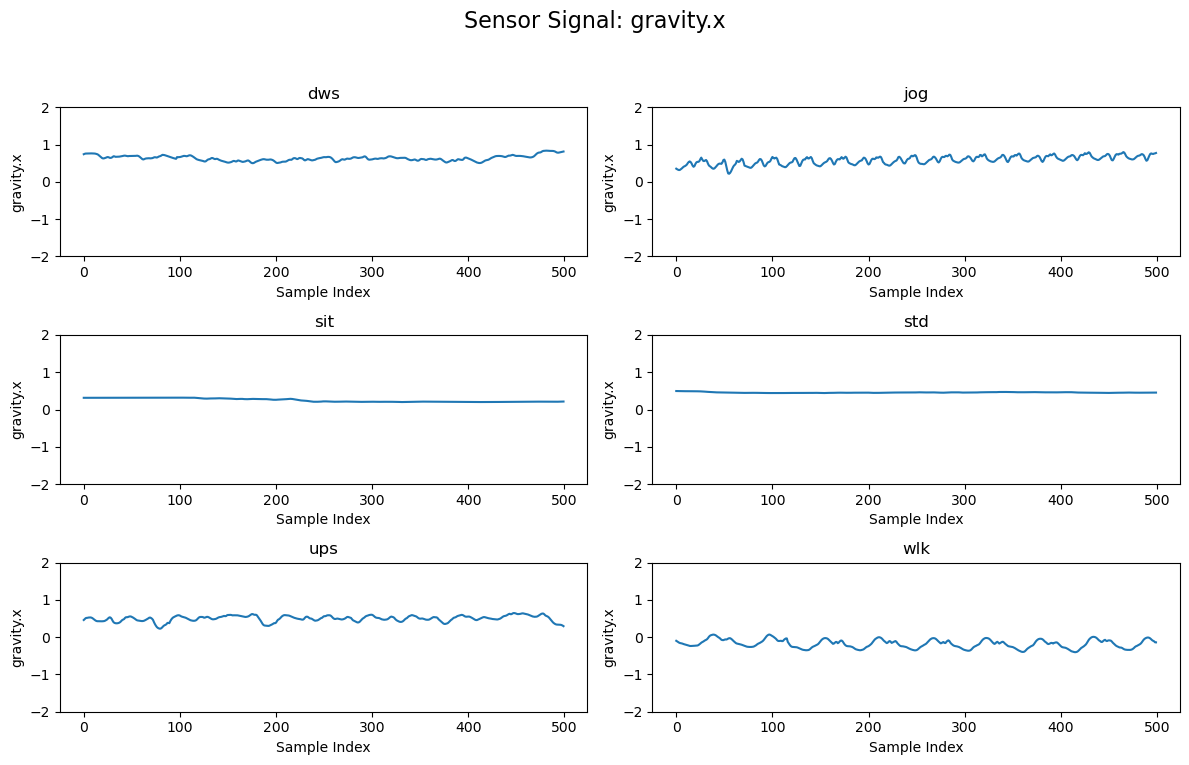

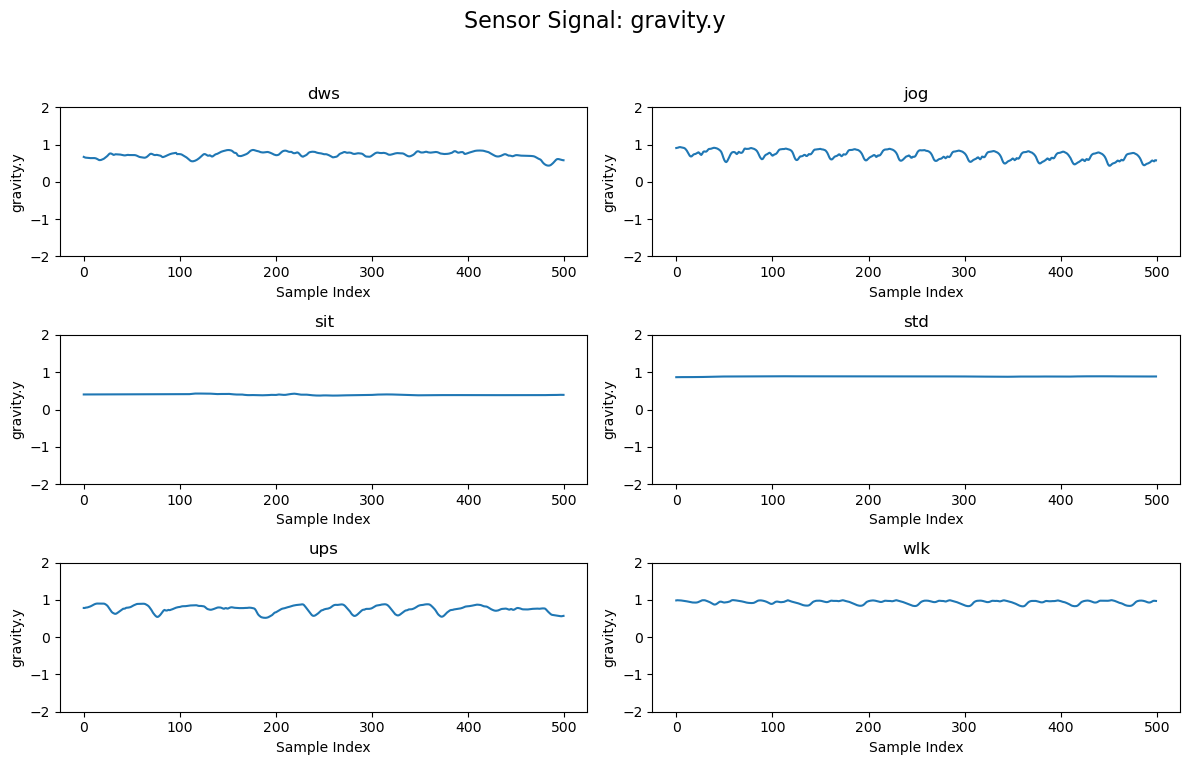

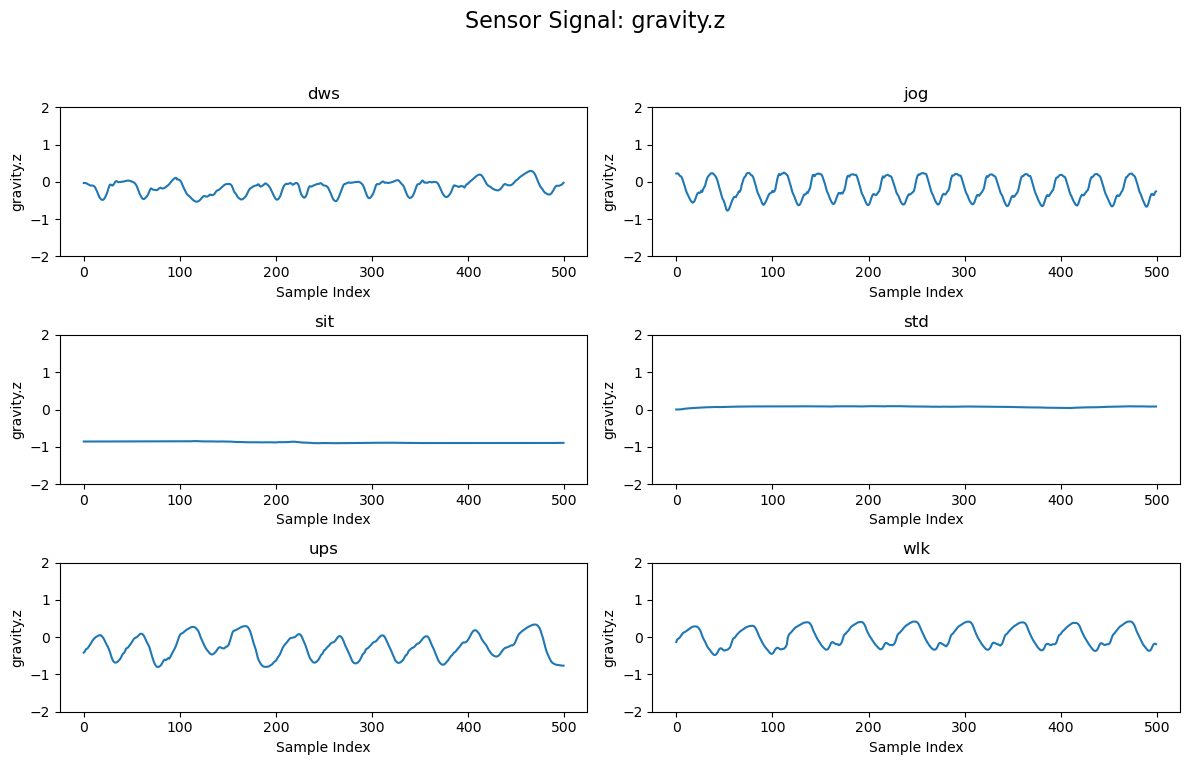

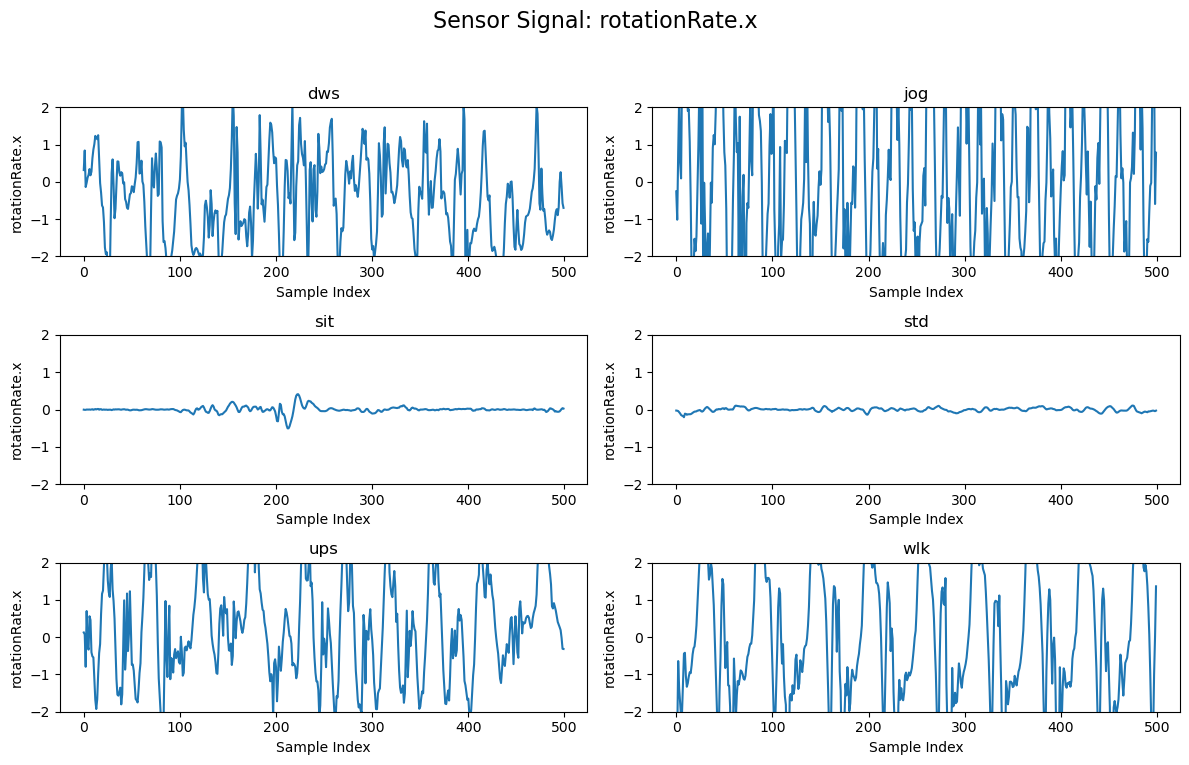

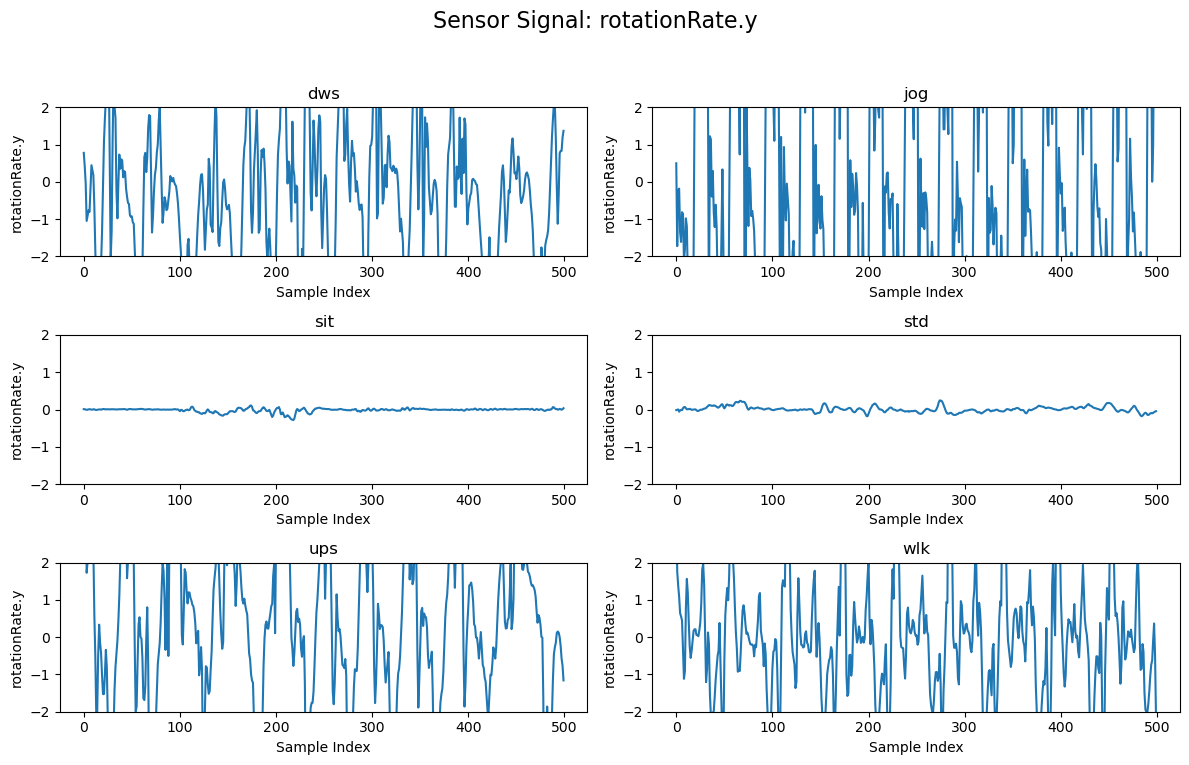

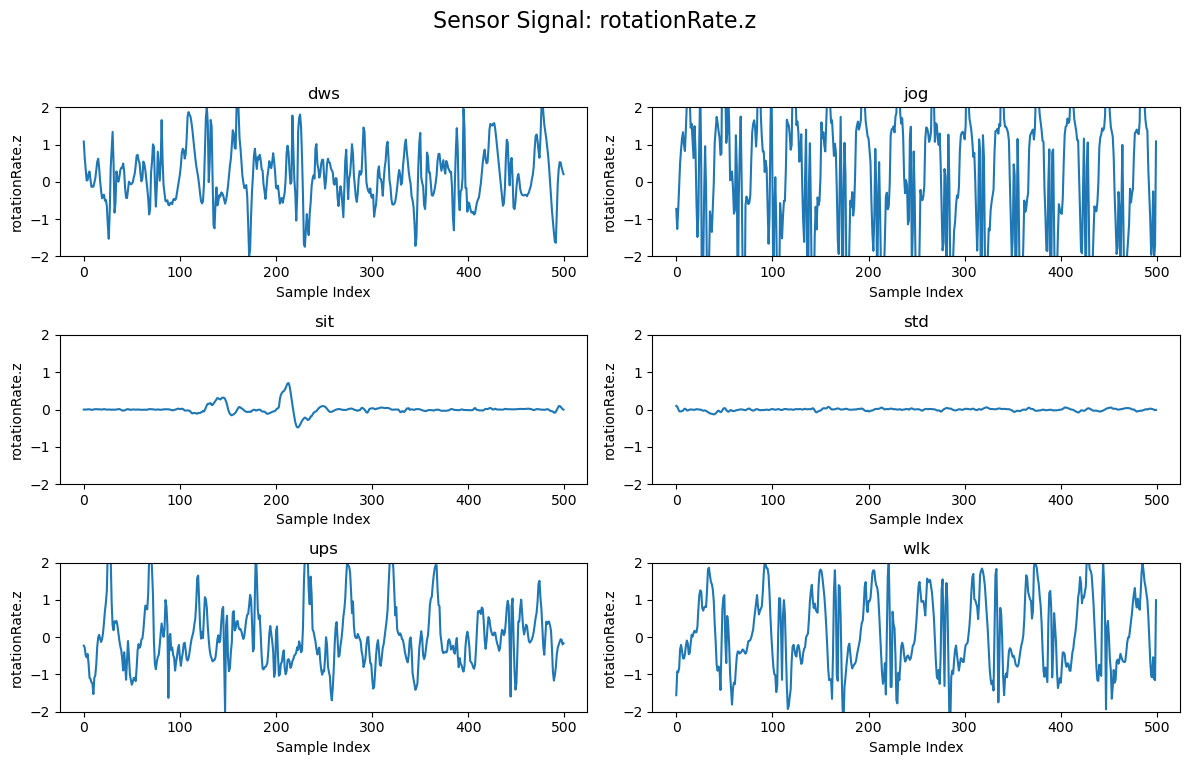

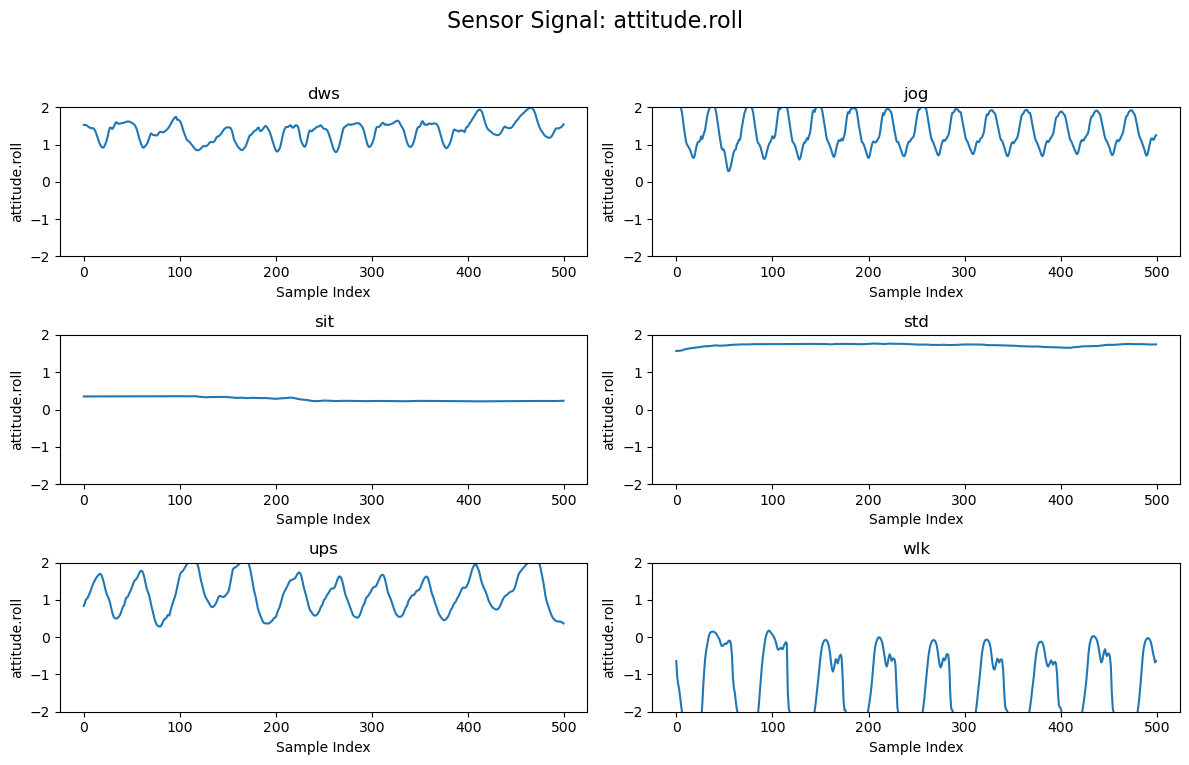

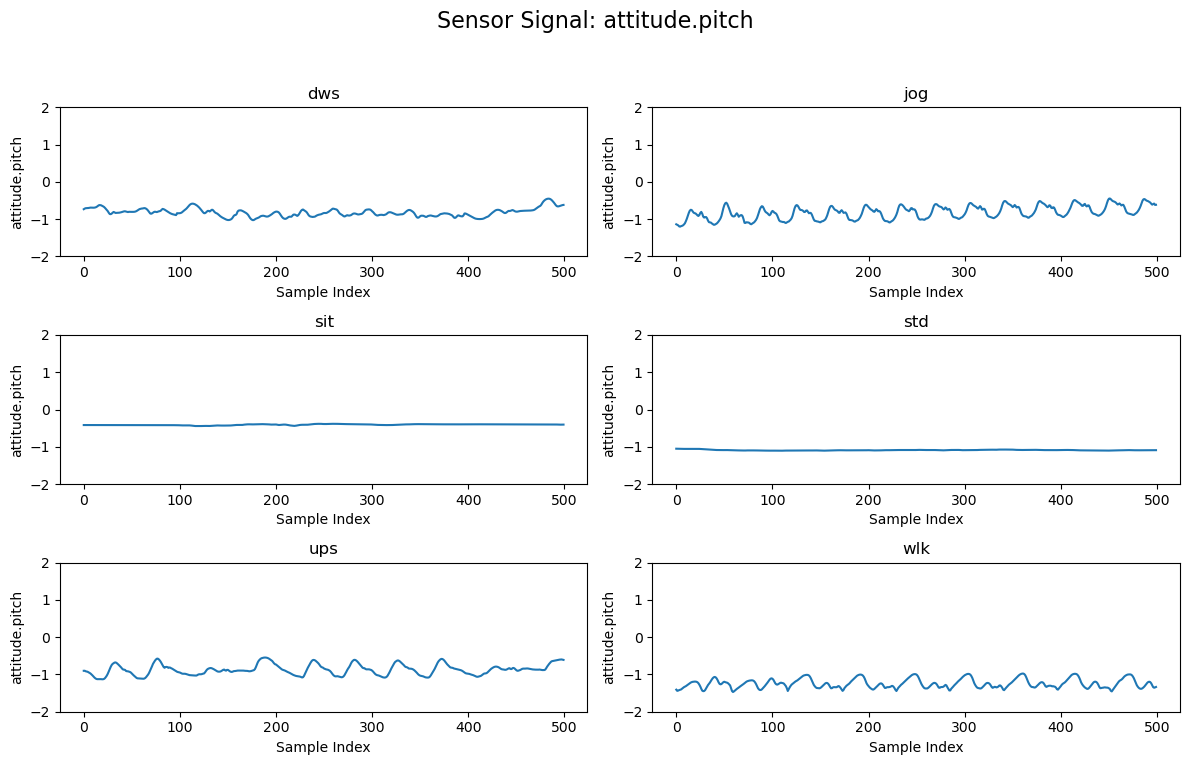

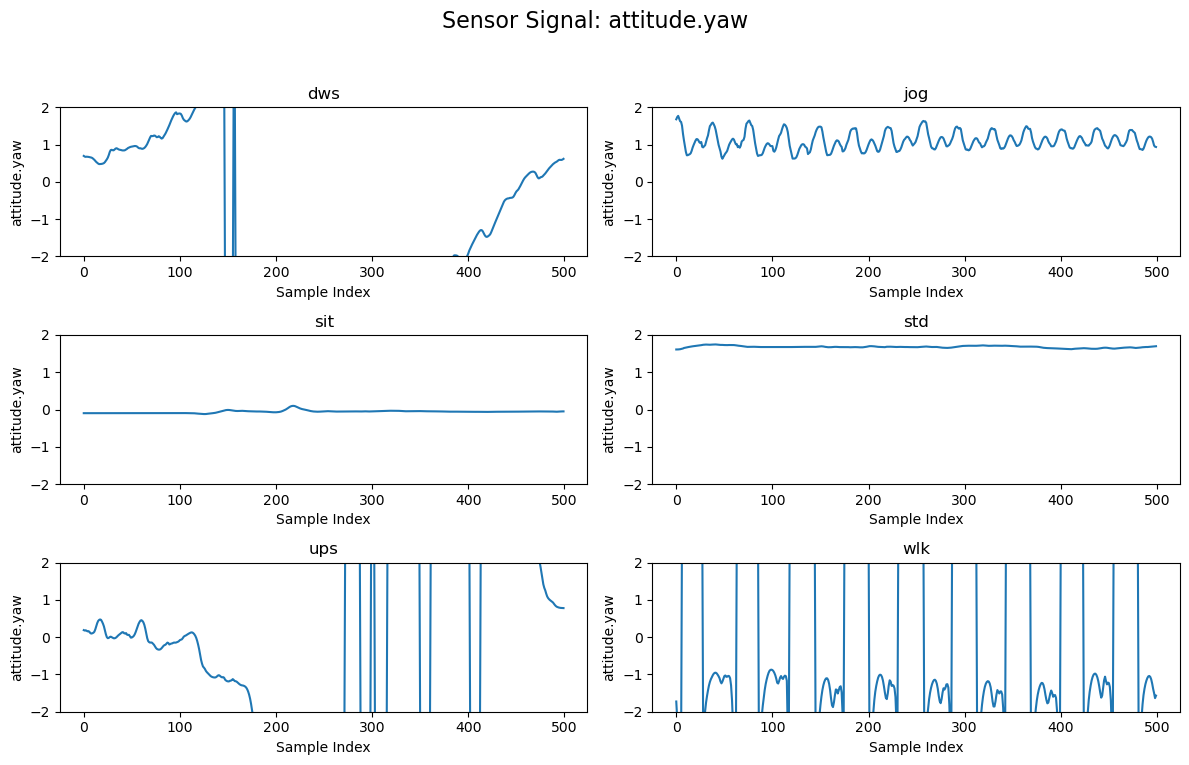

In [8]:
activity_names  = ['dws', 'jog', 'sit', 'std', 'ups', 'wlk']

# List of sensor columns you want to plot — adjust this based on your dataset
sensor_cols = [
    'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z',
    'gravity.x', 'gravity.y', 'gravity.z',
    'rotationRate.x', 'rotationRate.y', 'rotationRate.z',
    'attitude.roll', 'attitude.pitch', 'attitude.yaw'
]

# For visualization, plot all sensor signals for each activity in separate figures
for col in sensor_cols:
    plt.figure(figsize=(12, 8))
    plt.suptitle(f'Sensor Signal: {col}', fontsize=16)
    
    for i in range(len(activity_names)):
        D = Df_all[Df_all['Activity'] == i+1]
        
        plt.subplot(3, 2, i+1)
        plt.plot(D[col].values[:500])
        plt.title(activity_names [i])
        plt.ylim([-2, 2])  # Adjust y limits if needed based on your data range
        plt.xlabel('Sample Index')
        plt.ylabel(col)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave room for suptitle
    plt.show()

In [4]:
num_cols = Df_all.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove('Exp_num')  # don't include group key in calculations

# Mean
df_sum = Df_all.groupby('Exp_num')[num_cols].mean().reset_index()
df_sum.columns = ['Exp_num'] + [col.replace('.', '_') + '_mean' for col in num_cols]

# Median of squares
df_sum_SS = Df_all[num_cols].pow(2).groupby(Df_all['Exp_num']).median().reset_index()
df_sum_SS.columns = ['Exp_num'] + [col.replace('.', '_') + '_median_sq' for col in num_cols]

# Max
df_max = Df_all.groupby('Exp_num')[num_cols].max().reset_index()
df_max.columns = ['Exp_num'] + [col.replace('.', '_') + '_max' for col in num_cols]

# Min
df_min = Df_all.groupby('Exp_num')[num_cols].min().reset_index()
df_min.columns = ['Exp_num'] + [col.replace('.', '_') + '_min' for col in num_cols]

# Skew
df_skew = Df_all.groupby('Exp_num')[num_cols].skew().reset_index()
df_skew.columns = ['Exp_num'] + [col.replace('.', '_') + '_skew' for col in num_cols]

# Standard deviation
df_std = Df_all.groupby('Exp_num')[num_cols].std().reset_index()
df_std.columns = ['Exp_num'] + [col.replace('.', '_') + '_std' for col in num_cols]

In [5]:
# Concatenate features
Df_Features = pd.concat([
    df_max,
    df_sum[df_sum.columns[2:-2]],
    df_min[df_min.columns[2:-2]],
    df_sum_SS[df_sum_SS.columns[2:-2]],
    df_std[df_std.columns[2:-2]],
    df_skew[df_skew.columns[2:-2]]
], axis=1)

# Drop columns if they exist
cols_to_drop = [col for col in ['Exp_num', 'Unnamed: 0', 'Activity', 'Sub_Num'] if col in Df_Features.columns]
Df_Features_1 = Df_Features.drop(cols_to_drop, axis=1)

# Get labels from original data grouped by Exp_num
Labels = Df_all.groupby('Exp_num')['Activity'].first().values

Class_Num = len(Activity_Types)  # Number of activity classes

# Convert labels to zero-based indexing
Labels_zero_based = Labels - 1

In [6]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(Df_Features_1, Labels_zero_based, test_size=0.25, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Helper: Confusion matrix plot
def plot_confusion_matrix(cm, class_names, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

#  K-Nearest Neighbors (KNN)

KNN Accuracy: 0.9940


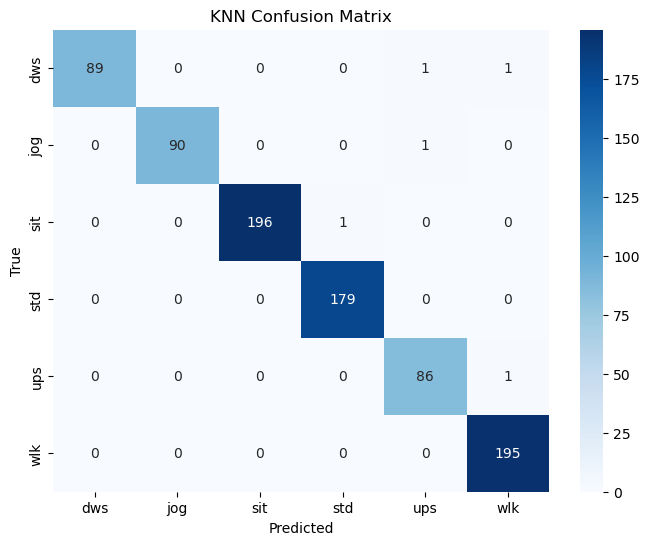

In [9]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

acc_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {acc_knn:.4f}")
plot_confusion_matrix(confusion_matrix(y_test, y_pred_knn), activity_names, "KNN Confusion Matrix")

 # Random Forest

Random Forest Accuracy: 0.9964


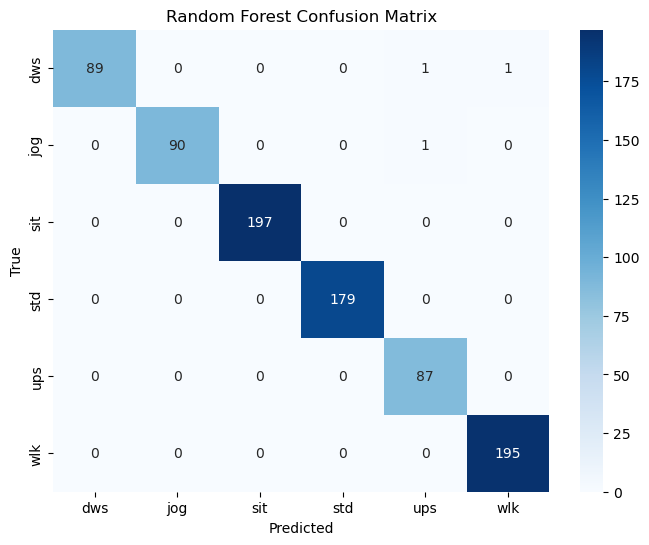

In [10]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {acc_rf:.4f}")
plot_confusion_matrix(confusion_matrix(y_test, y_pred_rf), activity_names, "Random Forest Confusion Matrix")


# XGBoost

C:\Users\phila\anaconda3\envs\tf_env\lib\site-packages\xgboost\training.py:183: UserWarning: [20:44:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.9988


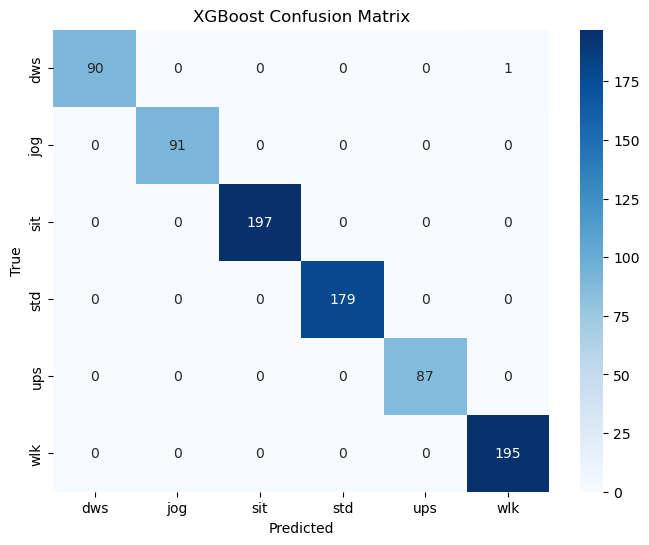

In [11]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {acc_xgb:.4f}")
plot_confusion_matrix(confusion_matrix(y_test, y_pred_xgb), activity_names, "XGBoost Confusion Matrix")


# Comparison

In [12]:
print("\n--- Model Performance Summary ---")
print(f"KNN Accuracy       : {acc_knn:.4f}")
print(f"Random Forest Acc  : {acc_rf:.4f}")
print(f"XGBoost Accuracy   : {acc_xgb:.4f}")



--- Model Performance Summary ---
KNN Accuracy       : 0.9940
Random Forest Acc  : 0.9964
XGBoost Accuracy   : 0.9988
